## Contrastive pre-training

Here, we will try the SimCLR method.

[1] T. Chen et al. “A Simple Framework for Contrastive Learning of Visual Representations”. In: ICML. 2020.


In [4]:
import os

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
torch.manual_seed(42) # Setting the seed

## Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import STL10, PCAM
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn

## Plot Options
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
plt.set_cmap("cividis")
%matplotlib inline
sns.set()

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Ensure that you are using GPU and all CPU workers
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

# For reproducibility
np.random.seed(666)
torch.manual_seed(666)

Device: cuda:0
Number of workers: 2


<Figure size 640x480 with 0 Axes>

### Data Augmentation for Contrastive Learning

One of the key points of SimCLR is the choice of the augmentation strategy. It composes many different geometric and iconographic transformations.
We can implement them very efficiently and easily using the Dataset object of Pytorch.

Since in SimCLR authors use 2 views, we do the same here. Please note that we could use more positives

The transformations used are: (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_data_augmentations.jpg" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

When using ImageNet-derived datasets, the two most important transformations are: crop-and-resize, and color distortion.
Interestingly, they need to be used together since, when combining randomly cropping and resizing, we might have two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/crop_views.svg" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in the representation space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view.
However, the network can use the color information (color histograms) to create a useless link between the two patches, without learning generalizable high-level representations. For instance, it could focus on the color of the fur of the dog and on the color of the background to understand that the two patches belong to the same image. That's why, we need to compose crop-and-resize and color distortion.

**Question**: Create a Pytorch class of transformations (transforms.Compose) where you apply the following augmentations:
- Resize an Crop
- Horizontal Flip
- Color jittering
- Gray scale changes
- Gaussian Blur

Hint: all functions have already been implemented and can be found here: https://pytorch.org/vision/0.9/transforms.html

Alternatively, you can also use [albumentations](https://albumentations.ai/) by simply adding:

`import albumentations as A`

`from albumentations.pytorch.transforms import ToTensorV2`

In [6]:
class ContrastiveTransformations:
    def __init__(self, img_size):
      # transformations applied in SimCLR article
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=img_size),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=int(0.1 * img_size))
        ])

        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    def __call__(self, x):
      # it outputs a tuple, namely 2 views (augmentations) fo the same image
        view1 = self.transform(x)
        view2 = self.transform(x)

        view1 = self.to_tensor(view1)
        view2 = self.to_tensor(view2)

        return view1, view2


We create unlabeled, training and test Datasets.
Please be careful since we use two different transformations, one for the unlabelled part and one for train/test set.

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import STL10

# simple transformation to use networks pre-trained on ImageNet
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

unlabeled_dataset_2viewsCon = STL10(root="./data", split="unlabeled", download=True, transform=ContrastiveTransformations(96))
train_dataset = STL10(root="./data", split="train", download=True, transform=img_transforms)
# just to show the effect of the augmentations and the classes
train_dataset_2viewsCon = STL10(root="./data", split="train", download=True, transform=ContrastiveTransformations(96))
test_dataset = STL10(root="./data", split="test", download=True, transform=img_transforms)

100%|██████████| 2640397119/2640397119 [01:34<00:00, 27891239.41it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**Question**: What's the difference between `ContrastiveTransformations` and `img_transforms` ? Look inside the functions and their outputs...

In [ ]:
#ContrastiveTransformations:
#Applies a more extensive set of augmentations suitable for contrastive learning.
#Generates two augmented views of each input image.
#Performs normalization using the ImageNet statistics.

#img_transforms:
#Applies simpler transformations, including only conversion to tensor and normalization using fixed mean and standard deviation values.
#Does not generate multiple views of each image.

In [ ]:
import numpy as np

# To check the classes in STL10
classes=unlabeled_dataset_2viewsCon.classes
print(classes)
print('Number images in Unlabeled dataset:' ,len(unlabeled_dataset_2viewsCon))
print(unlabeled_dataset_2viewsCon[0][0][0].shape) # this is one image (the first of the 2-views tuple)

# Train dataset
labels=train_dataset.labels # retrieve label of each sample
print('Number images in Train dataset:' , len(train_dataset)) # retrieve length of dataset
print(train_dataset[3][0].shape) # this is one image

#Test dataset
print('Number images in Test dataset:' ,len(test_dataset))
print(test_dataset[0][0].shape) # this is one image

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Number images in Unlabeled dataset: 100000
torch.Size([3, 96, 96])
Number images in Train dataset: 5000
torch.Size([3, 96, 96])
Number images in Test dataset: 8000
torch.Size([3, 96, 96])


The Unlabeled dataset contains 100k images. Here, to limit memory requirement, we will use 10% of the data.

In [ ]:
from torch.utils.data import random_split

sizeUnlabelled=5000

unlabeled_dataset_2viewsCon_red,rest = random_split(unlabeled_dataset_2viewsCon, [sizeUnlabelled, len(unlabeled_dataset_2viewsCon)-sizeUnlabelled])
len(unlabeled_dataset_2viewsCon_red)
del unlabeled_dataset_2viewsCon # free memory

We can also create a function to visualize the views of each sample, based on the chosen augmentation strategy.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def imshowSTL102views(datasetOrig,datasetTransform,rows=5,figsize=(8, 15)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, 3*(rows-1)+2,3):
      imgOrig = datasetOrig[i][0]
      img1=datasetTransform[i][0][0]
      img2=datasetTransform[i][0][1]

      #REMOVE NORMALIZATION
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
      # Clip values to range [0,1] -> possible rounding errors during normalization
      imgOrig = np.clip(unnormalize(imgOrig).numpy(),0,1)
      img1 = np.clip(unnormalize(img1).numpy(),0,1)
      img2 = np.clip(unnormalize(img2).numpy(),0,1)

      label = datasetOrig[i][1]
      fig.add_subplot(rows, 3, i)
      plt.title(datasetOrig.classes[label]+ ' , original')
      plt.imshow(np.transpose(imgOrig, (1, 2, 0)))
      plt.axis("off")
      fig.add_subplot(rows, 3, i+1)
      plt.title(datasetOrig.classes[label] + ' , 1st view')
      plt.imshow(np.transpose(img1, (1, 2, 0)))
      plt.axis("off")
      fig.add_subplot(rows, 3, i+2)
      plt.title(datasetOrig.classes[label] + ' , 2nd view')
      plt.imshow(np.transpose(img2, (1, 2, 0)))
      plt.axis("off")
    plt.show()

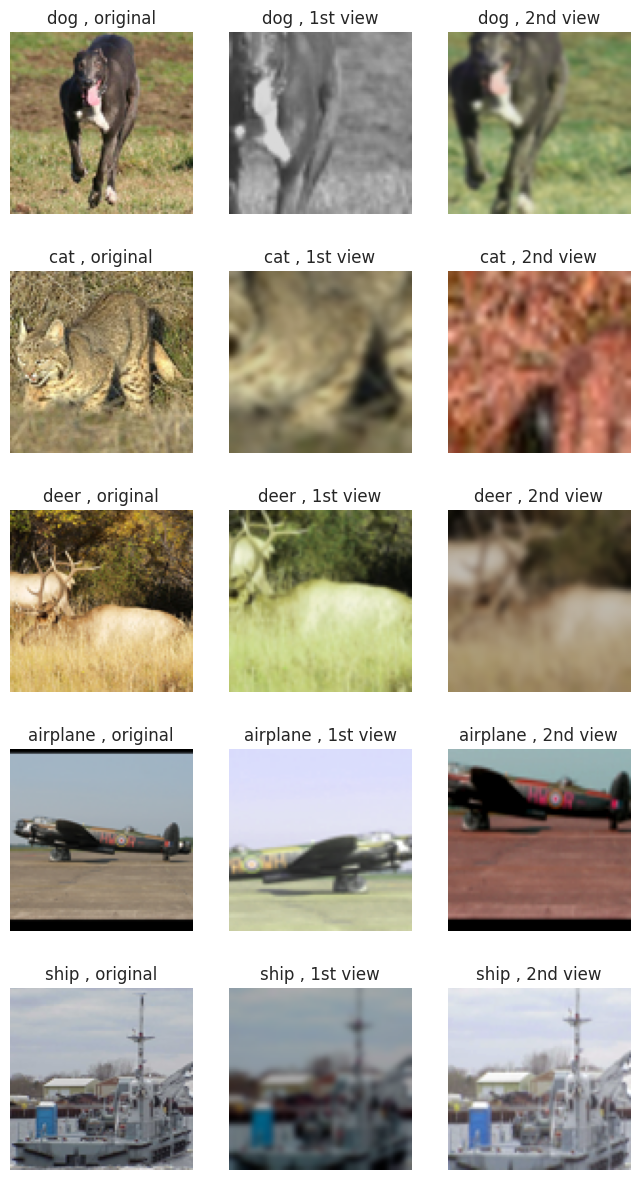

In [ ]:
imshowSTL102views(train_dataset,train_dataset_2viewsCon)

In [ ]:
del train_dataset_2viewsCon # To free memory

Here, it's the most important part of the code.

I remind you that the Siamese architecture of SimCLR is: (figure credit - [Ting Chen et al. ](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_network_setup.svg" width="350px"></center>

The employed loss is the InfoNCE loss:
$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$
where $\tau$ is the temperature and the similarity measure is the cosine similarity:
$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$
The maximum cosine similarity possible is $1$, while the minimum is $-1$.

After training, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor.


**Question**: Fill the code where you see **XXXXXXXXXXXXXXXXXX**

In [ ]:

import shutil
import yaml
import logging
import os
import sys

import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

torch.manual_seed(0)


class SimCLR():

    def __init__(self, model, optimizer, scheduler, device, batch_size, temperature, epochs):
        self.device=device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.temperature=temperature
        self.batch_size=batch_size
        self.epochs=epochs


    def cosine_similarity(self, z1, z2):
        similarity = torch.matmul(z1, z2.T) / (torch.norm(z1, dim=1, keepdim=True) * torch.norm(z2, dim=1, keepdim=True))
        return similarity

    def info_nce_loss(self, features):
        batch_size = features.shape[0] // 2  # Divide by 2 since we concatenate views
        features = F.normalize(features, dim=1)
        z1, z2 = torch.split(features, batch_size)
        similarity_matrix = self.cosine_similarity(z1, z2)
        numerator = torch.exp(similarity_matrix / self.temperature)
        mask = torch.eye(batch_size, device=self.device, dtype=torch.bool)
        pos_samples = numerator.masked_select(mask).view(batch_size, 1)
        neg_samples = torch.sum(numerator, dim=1) - pos_samples.view(-1)
        loss = -torch.log(pos_samples / (pos_samples + neg_samples)).mean()
        return loss

    def train(self, train_loader):

        scaler = GradScaler() # gradient scaling, useful when we use float16

        n_iter = 0
        print("Start SimCLR training for {} epochs.".format(self.epochs))

        for epoch_counter in range(self.epochs):
            for images, _ in tqdm(train_loader):

                images = torch.cat([images[0], images[1]], dim=0)

                images = images.to(self.device)

                with autocast(dtype=torch.float16): # to improve performance while maintaining accuracy.
                #with autocast():
                    features = self.model(images)
                    loss = self.info_nce_loss(features)

                self.optimizer.zero_grad()

                scaler.scale(loss).backward()

                scaler.step(self.optimizer)
                scaler.update()

                n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 5:
                self.scheduler.step()

            print('Epoch: {}, Average loss: {:.4f}, lr: {:.4f}'.format(epoch_counter, loss / len(train_loader.dataset), self.scheduler.get_last_lr()[0] ))

        print("Training has finished.")

As before, we use a DataLoader.

DataLoader wraps an iterable around the Dataset to enable easy access to the samples. The Dataset retrieves our dataset features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.




In [ ]:
import torch.utils.data as data

bs = 16 # choose an appropriate batch size depending on the computational resources

train_unlabelled_loader = DataLoader(dataset=unlabeled_dataset_2viewsCon_red, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)



Here we define the hyper-parameters, optimization, scheduler and launch the training.

**Question**: complete the code where you see XXXXX.

As model for $f()$, use a ResnNet18 not-pretrained. Remember that the model ResNet18 has already a Linear Layer at the end (fc) which can be written as $Wf(x)$. You can also change the `out_features` of the fc by adding the option `num_classes=XXXX` while loading the model.

 As projection head, use the one from the article

 $$ g(f(x))=W^a \sigma (W^b f(x))$$

 where $\sigma$ is a Relu non-linearity.

In [ ]:
max_epochs=10
lr=0.003
wd=1e-4
temperature=0.07
#f_dim=512 # to use if you want to change the output dimension of f
g_dim=128 # the output dimension of the projection head

# Ensure that you are using GPU and all CPU workers
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, g_dim)  # Adjust the output dimension of the projection head
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_unlabelled_loader), eta_min=0, last_epoch=-1)

simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, device=device, batch_size=bs, temperature=temperature, epochs=max_epochs)
simclr.train(train_unlabelled_loader)

# save model checkpoints
os.makedirs('models/', exist_ok=True)
filename = 'models/resnet18_simclr_50epochs_stl10.pth.tar'
torch.save({
                'epoch': max_epochs,
                'state_dict': simclr.model.state_dict()
            }, filename)

Device: cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Start SimCLR training for 10 epochs.


100%|██████████| 312/312 [01:04<00:00,  4.80it/s]


Epoch: 0, Average loss: 0.0006, lr: 0.0030


100%|██████████| 312/312 [00:38<00:00,  8.16it/s]


Epoch: 1, Average loss: 0.0005, lr: 0.0030


100%|██████████| 312/312 [00:36<00:00,  8.44it/s]


Epoch: 2, Average loss: 0.0004, lr: 0.0030


100%|██████████| 312/312 [00:46<00:00,  6.75it/s]


Epoch: 3, Average loss: 0.0005, lr: 0.0030


100%|██████████| 312/312 [00:45<00:00,  6.84it/s]


Epoch: 4, Average loss: 0.0005, lr: 0.0030


100%|██████████| 312/312 [00:37<00:00,  8.43it/s]


Epoch: 5, Average loss: 0.0005, lr: 0.0030


100%|██████████| 312/312 [00:37<00:00,  8.40it/s]


Epoch: 6, Average loss: 0.0004, lr: 0.0030


100%|██████████| 312/312 [00:37<00:00,  8.26it/s]


Epoch: 7, Average loss: 0.0004, lr: 0.0030


100%|██████████| 312/312 [00:37<00:00,  8.33it/s]


Epoch: 8, Average loss: 0.0005, lr: 0.0030


100%|██████████| 312/312 [00:40<00:00,  7.71it/s]

Epoch: 9, Average loss: 0.0004, lr: 0.0030
Training has finished.


To continue, you can use a model that I have already pre-trained for 50 epochs.

In [ ]:
import torchvision.models as models
import gdown

# Creating dataset folder
os.makedirs('models/', exist_ok=True)
filename = 'models/resnet18_simclr_100epochs_stl10.pth.tar'

# Download the pre-trained model
file_url = 'https://drive.google.com/uc?id=13_ZueA9mqh17GvYVkfU_Yokg3z065rKG'
gdown.download(file_url, filename, quiet=True)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

# Since we will only use f, we can load the original resnet18 (ignoring the projector g)
modelDownload = models.resnet18(weights=None)

checkpoint = torch.load(filename, map_location=device)
state_dict= checkpoint['state_dict']
# strict=False is important since here we are only copying the values for f ignoring the projector g
modelDownload.load_state_dict(state_dict, strict=False)
epoch = checkpoint['epoch']


Using device: cuda:0


As previously explained, we can now use $f()$ to encode the samples discarding $g()$.


**Question** How can you discard the projection ? Complete the code.

In [ ]:
from copy import deepcopy
import torch.nn as nn

@torch.no_grad()
def prepare_data_features(model, dataset, batchsize,  device):
    # Prepare model
    network = deepcopy(model)

    # you need to modify network here
    network.fc = nn.Identity()

    network.eval() # we are testing, parameters are frozen
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=batchsize, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)

    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels), [feats.numpy() , labels.numpy()]

We can use either the trained model or the donwladed model and encode the train and test images.

In [ ]:
#modelTrained=simclr.model
modelTrained=modelDownload
trainloader, [train_feats, train_labels] = prepare_data_features(modelTrained, train_dataset, batchsize=256, device=device)
testloader, [test_feats, test_labels] = prepare_data_features(modelTrained, test_dataset, batchsize=256, device=device)
print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

100%|██████████| 32/32 [00:06<00:00,  5.11it/s]

(5000, 512) (5000,)
(8000, 512) (8000,)


**Linear Probe**:  we train a logistic regression on the train dataset and evaluate it on the test dataset. This is called Linear Probe.

**Question**: compute the training and test errore using a logistic regression where you are free to use a regularization.

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

def train_linear_probe(train_features, train_labels, test_features, test_labels, regularization='l2'):

    clf = LogisticRegression(penalty=regularization, max_iter=1000, random_state=42)
    clf.fit(train_features, train_labels)
    train_preds = clf.predict(train_features)
    test_preds = clf.predict(test_features)
    train_error = 1.0 - accuracy_score(train_labels, train_preds)
    test_error = 1.0 - accuracy_score(test_labels, test_preds)

    return train_error, test_error

train_error, test_error = train_linear_probe(train_feats, train_labels,
                                             test_feats, test_labels, regularization='l2')

print("Training error:", train_error)
print("Test error:", test_error)

Training error: 0.3802
Test error: 0.50075


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


What if we simply used a pre-trained model on ImageNet ? ...

**Question**: use the previous function `prepare_data_features` with a resnet18 pre-trained on Imagenet (without simclr pretraining) and compute the Linear Probe as before.

In [ ]:
from sklearn.linear_model import LogisticRegression
import torchvision.models as models

modelImageNet = models.resnet18(pretrained=True)


# Prepare data features
trainloader, [train_feats, train_labels] = prepare_data_features(modelImageNet, train_dataset, batchsize=256, device=device)
testloader, [test_feats, test_labels] = prepare_data_features(modelImageNet, test_dataset, batchsize=256, device=device)

print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

# Train linear probe and compute errors
train_error, test_error = train_linear_probe(train_feats, train_labels,
                                             test_feats, test_labels, regularization='l2')

print("Training error:", train_error)
print("Test error:", test_error)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.4MB/s]
100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


(5000, 512) (5000,)
(8000, 512) (8000,)
Training error: 0.0
Test error: 0.13637500000000002


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Question**: is the result better ? Why in your opinion ? What could you do to improve the method with the worst result ?



In [ ]:
# Normally we need to get a better result.
# Using a model pretrained on ImageNet will give accurate transformations
# which will help the linear regression to learn better features.

# To improve the method with the worst result, we can think of a data augmentation
# to remediate to the fact that the resnet18 is not pretrained.

To go further, you could use the PatchCamelyon dataset (https://www.kaggle.com/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon).

The PatchCamelyon benchmark is a image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue.

You can donwload it from pytorch vision or, if you are using Google Colab, directly from our Google drive. The pytorch version needs to be unzipped and there is not enough RAM memory...

Please do not change the following code.

In [ ]:
import gdown
import zipfile

# Creating dataset folder
!mkdir /content/pcam

# Download the Train set
file_url = 'https://drive.google.com/uc?id=1ipIG12YWag54v2_2JIyfPiZDN0Eu3IjB'
output_path = '/content/pcam/camelyonpatch_level_2_split_train_x.h5'
gdown.download(file_url, output_path, quiet=False)

# Download Valid set
file_url = 'https://drive.google.com/uc?id=1emdhTV8J8Pv-SjKSoMzE_SbT04Ik2yUm'
output_path = '/content/pcam/camelyonpatch_level_2_split_valid_x.h5'
gdown.download(file_url, output_path, quiet=False)

# Download Test set
file_url = 'https://drive.google.com/uc?id=1dkeFapKSKm-wUtf9zicxiSHWIS0uxv8Z'
output_path = '/content/pcam/camelyonpatch_level_2_split_test_x.h5'
gdown.download(file_url, output_path, quiet=False)

# Download the labels
file_url = 'https://drive.google.com/uc?id=10ftBj2ZiiDESTsANdF-v8oh4NieinYPP'
output_path = '/content/label.zip'
gdown.download(file_url, output_path, quiet=False)

# Unzip and move to data directory
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(output_path[:-4])
!mv /content/label/Labels/camelyonpatch_level_2_split_train_y.h5 /content/pcam
!mv /content/label/Labels/camelyonpatch_level_2_split_test_y.h5 /content/pcam
!mv /content/label/Labels/camelyonpatch_level_2_split_valid_y.h5 /content/pcam




In [ ]:
#This error occured when executing the previous code: Too many users have viewed or downloaded this file recently.
#Please try accessing the file again later. If the file you are trying to access is particularly large or
#is shared with many people, it may take up to 24 hours to be able to view or download the file.
#If you still can't access a file after 24 hours, contact your domain administrator.


Now you can load it using the PCAM Dataset and DataLoader (keep download as False since you have already downloaded the data)

In the following, you will use the training split as if it was unlabeled, thus for the self-supervised part, then the val split as if it was the training set and the test split as test set.

In [ ]:
img_size=96
bs = 128

# ### PCAM Dataset

PCAM_unlabeled_dataset = PCAM(root="", download=False, split='train', transform=ContrastiveTransformations(img_size))
PCAM_train_dataset = PCAM(root="", download=False, split='val', transform=transforms.ToTensor())
PCAM_test_dataset = PCAM(root="", download=False, split='test', transform=transforms.ToTensor())
print('There are: ', len(PCAM_unlabeled_dataset), 'training images; ', len(PCAM_train_dataset), ' validation images; and ', len(PCAM_test_dataset), ' test images')


PCAM_unlabeled_loader = DataLoader(dataset=PCAM_unlabeled_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True)
PCAM_train_loader = DataLoader(PCAM_train_dataset, batch_size=bs)
PCAM_test_loader = DataLoader(PCAM_test_dataset, batch_size=bs)


# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")


We can visualize the images as before

In [ ]:
# Visualize some examples
NUM_IMAGES = 12
PCAM_images = torch.stack([PCAM_train_dataset[np.random.randint(len(PCAM_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(PCAM_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the PCAM dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

**Question**: As before, train the SimCLR algorithm on the unlabeled set and then train and test the Linear Probe.

This time, you can initialize the model as a ResNet-18 pre-trained on ImageNet and then train the simclr model for just 10 epochs.
If you want to speed up the computations (a bit) you can also reduce the size of the images

In [ ]:
import torchvision.models as models
import torch.nn as nn

max_epochs=2
lr=0.003
wd=1e-4
temperature=0.07
# Ensure that you are using GPU and all CPU workers
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


model = models.resnet18(weights=None, num_classes=128)
dim_mlp = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), model.fc)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_unlabelled_loader), eta_min=0, last_epoch=-1)

simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, device=device, batch_size=bs, temperature=temperature, epochs=max_epochs)
simclr.train(PCAM_unlabeled_loader)

# save model checkpoints
os.makedirs('models/', exist_ok=True)
filename = 'models/resnet18_simclr_100epochs_PCAM.pth.tar'
torch.save({
                'epoch': max_epochs,
                'state_dict': simclr.model.state_dict()
            }, filename)

**Question**: Using the linear probe, test whether the self-supervised training (for 10 or more epochs) improves the results over a simple ResNet18 only pre-trained on ImageNet. What would you do to improve the results if you had more time ?

In [ ]:
from sklearn.linear_model import LogisticRegression
import torchvision.models as models



# Prepare data features
trainloader, [train_feats, train_labels] = prepare_data_features(simclr, train_dataset, batchsize=256, device=device)
testloader, [test_feats, test_labels] = prepare_data_features(simclr, test_dataset, batchsize=256, device=device)

print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

# Train linear probe and compute errors
train_error, test_error = train_linear_probe(train_feats, train_labels,
                                             test_feats, test_labels, regularization='l2')

print("Training error:", train_error)
print("Test error:", test_error)

In [ ]:
# Normally, we will find that using a self-supervised training won't improve the results over
# a simple ResNet18 only pre-trained on ImageNet.

# What we could improve is using some augmentation techniques to get better representations.